In [1]:
# Import necessary libraries
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# --- 1. CONNECT TO THE DATABASE ---

# Load environment variables from .env file
# Make sure your .env file is in the root of your project directory
load_dotenv()

# Get database credentials from environment variables
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# Create the database connection string
db_url = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Create a SQLAlchemy engine
engine = create_engine(db_url)
print("Successfully connected to the PostgreSQL database.")


# --- 2. DEFINE THE SQL QUERY ---

# This query joins all our tables to create a single analytical dataset.
# It calculates the number of news articles for each stock on each day.
query = text("""
    SELECT
        d.full_date,
        t.ticker_symbol,
        p.open_price,
        p.high_price,
        p.low_price,
        p.close_price,
        p.adj_close_price,
        p.volume,
        COALESCE(n.news_count, 0) AS news_count -- If a day has no news, count is 0
    FROM 
        fact_stock_prices AS p
    JOIN 
        dim_tickers AS t ON p.ticker_id = t.ticker_id
    JOIN 
        dim_dates AS d ON p.date_id = d.date_id
    LEFT JOIN (
        -- Subquery to count news articles per ticker per day
        SELECT
            ticker_id,
            date_id,
            COUNT(article_id) AS news_count
        FROM 
            fact_news_articles
        GROUP BY 
            ticker_id, date_id
    ) AS n ON p.ticker_id = n.ticker_id AND p.date_id = n.date_id
    ORDER BY 
        t.ticker_symbol, d.full_date;
""")


# --- 3. EXECUTE THE QUERY AND LOAD DATA INTO PANDAS ---

with engine.connect() as connection:
    df = pd.read_sql(query, connection)

# Display the first few rows and info to verify
print("\nData successfully fetched from the database.")
print("DataFrame Info:")
df.info()

print("\nFirst 5 rows of the combined data:")
df.head()

Successfully connected to the PostgreSQL database.

Data successfully fetched from the database.
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   full_date        315 non-null    object 
 1   ticker_symbol    315 non-null    object 
 2   open_price       315 non-null    float64
 3   high_price       315 non-null    float64
 4   low_price        315 non-null    float64
 5   close_price      315 non-null    float64
 6   adj_close_price  315 non-null    float64
 7   volume           315 non-null    int64  
 8   news_count       315 non-null    int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 22.3+ KB

First 5 rows of the combined data:


,full_date,ticker_symbol,open_price,high_price,low_price,close_price,adj_close_price,volume,news_count
0,2025-06-02,AAPL,200.279999,202.130005,200.119995,201.699997,201.471344,35423300,0
1,2025-06-03,AAPL,201.350006,203.770004,200.960007,203.270004,203.039566,46381600,0
2,2025-06-04,AAPL,202.910004,206.240005,202.100006,202.820007,202.590088,43604000,0
3,2025-06-05,AAPL,203.500000,204.750000,200.149994,200.630005,200.402573,55126100,0
4,2025-06-06,AAPL,203.000000,205.699997,202.050003,203.919998,203.688828,46607700,0


In [3]:
# Statistical summary of the numerical columns
df.describe()

,open_price,high_price,low_price,close_price,adj_close_price,volume,news_count
count,315.000000,315.000000,315.000000,315.000000,315.000000,3.150000e+02,315.000000
mean,369.671174,372.844603,366.186221,369.448158,369.246443,3.280377e+07,1.311111
std,213.488752,215.005545,211.155654,212.870847,212.785837,2.095103e+07,10.402644
min,166.270004,167.339996,162.000000,165.190002,165.190002,6.861200e+06,0.000000
25%,204.449997,207.620003,202.130005,204.544998,204.418701,1.646435e+07,0.000000
50%,226.270004,229.089996,224.759995,227.179993,227.179993,3.037060e+07,0.000000
75%,514.739990,515.554993,509.779999,512.535004,511.693817,4.056390e+07,0.000000
max,791.150024,796.250000,780.820007,790.000000,790.000000,1.222588e+08,96.000000


In [4]:
# Check for any missing values
df.isnull().sum()

full_date          0
ticker_symbol      0
open_price         0
high_price         0
low_price          0
close_price        0
adj_close_price    0
volume             0
news_count         0
dtype: int64

Matplotlib is building the font cache; this may take a moment.


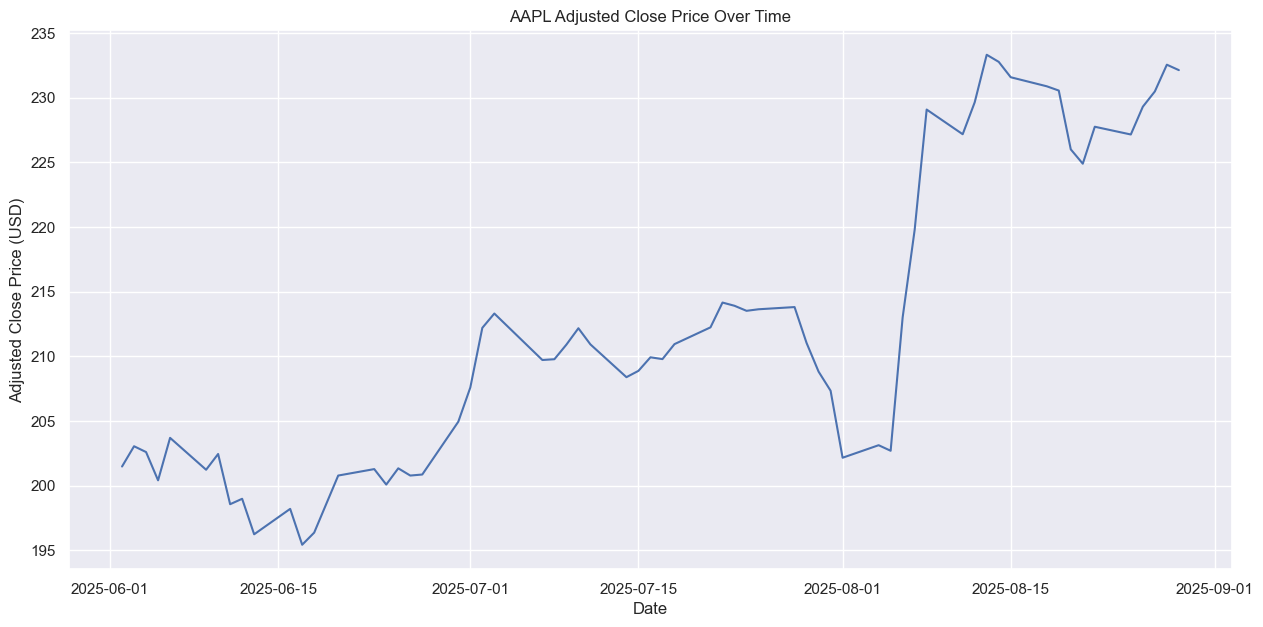

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="darkgrid")
plt.figure(figsize=(15, 7))

# Plot the adjusted closing price for Apple (AAPL)
aapl_df = df[df['ticker_symbol'] == 'AAPL']
sns.lineplot(x='full_date', y='adj_close_price', data=aapl_df)

plt.title('AAPL Adjusted Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.show()

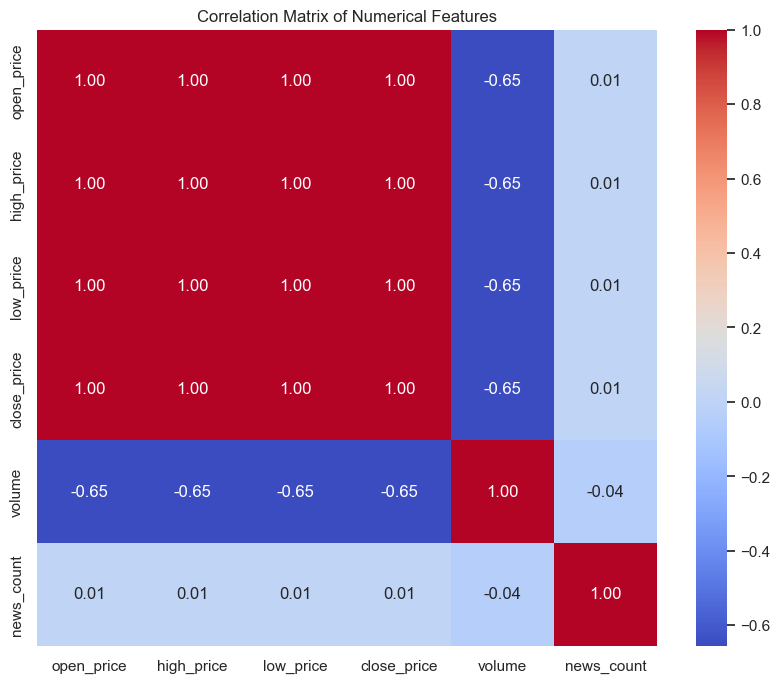

In [6]:
# Select only numerical columns for correlation calculation
numerical_df = df[['open_price', 'high_price', 'low_price', 'close_price', 'volume', 'news_count']].copy()

# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [7]:
# --- Define the Target Variable ---
# We want to predict if the next day's price will be higher (1) or lower (0)
# We use .shift(-1) to bring the next day's closing price to the current row
df['future_close'] = df.groupby('ticker_symbol')['adj_close_price'].shift(-1)
df['target'] = (df['future_close'] > df['adj_close_price']).astype(int)

# --- Create Features ---
# We'll use past data (lags) to predict the future
lags = [1, 2, 5, 10] # e.g., price from 1 day ago, 2 days ago, etc.
for lag in lags:
    # Price change from 'lag' days ago
    df[f'price_change_lag_{lag}'] = df.groupby('ticker_symbol')['adj_close_price'].pct_change(periods=lag)
    # News count from 'lag' days ago
    df[f'news_count_lag_{lag}'] = df.groupby('ticker_symbol')['news_count'].shift(lag)

# Moving Averages
df['ma_5'] = df.groupby('ticker_symbol')['adj_close_price'].rolling(window=5).mean().reset_index(0, drop=True)
df['ma_10'] = df.groupby('ticker_symbol')['adj_close_price'].rolling(window=10).mean().reset_index(0, drop=True)

# --- Clean Up ---
# Drop rows with NaN values created by lags and moving averages
df_model = df.dropna()

print("Shape of the final model-ready DataFrame:", df_model.shape)
df_model.head()

Shape of the final model-ready DataFrame: (260, 21)


,full_date,ticker_symbol,open_price,high_price,low_price,close_price,adj_close_price,volume,news_count,future_close,...,price_change_lag_1,news_count_lag_1,price_change_lag_2,news_count_lag_2,price_change_lag_5,news_count_lag_5,price_change_lag_10,news_count_lag_10,ma_5,ma_10
10,2025-06-16,AAPL,197.300003,198.690002,196.559998,198.419998,198.195068,43020700,0,195.418213,...,0.010028,0.0,-0.003916,0.0,-0.015041,0.0,-0.016262,0.0,198.878290,200.533414
11,2025-06-17,AAPL,197.199997,198.389999,195.210007,195.639999,195.418213,38856200,0,196.357147,...,-0.014011,0.0,-0.004123,0.0,-0.034687,0.0,-0.037536,0.0,197.473883,199.771278
12,2025-06-18,AAPL,195.940002,197.570007,195.070007,196.580002,196.357147,45394700,0,200.772141,...,0.004805,0.0,-0.009273,0.0,-0.011068,0.0,-0.030766,0.0,197.034381,199.147984
13,2025-06-20,AAPL,198.240005,201.699997,196.860001,201.000000,200.772141,96813500,0,201.271576,...,0.022485,0.0,0.027397,0.0,0.009036,0.0,0.001844,0.0,197.393973,199.184941
14,2025-06-23,AAPL,201.630005,202.300003,198.960007,201.500000,201.271576,55814300,0,200.072937,...,0.002488,0.0,0.025028,0.0,0.025706,0.0,-0.011867,0.0,198.402829,198.943216


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- Prepare Data for Modeling ---
features = [
    'news_count', 'volume',
    'price_change_lag_1', 'price_change_lag_2', 'price_change_lag_5', 'price_change_lag_10',
    'news_count_lag_1', 'news_count_lag_2', 'news_count_lag_5', 'news_count_lag_10',
    'ma_5', 'ma_10'
]

X = df_model[features]
y = df_model['target']

# --- Time-Based Train-Test Split ---
# We train on the first 80% of the data and test on the most recent 20%
split_index = int(len(X) * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# --- Train the Model ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Evaluate the Model ---
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))

Training set size: 208
Test set size: 52

Model Accuracy: 0.5192

Classification Report:
              precision    recall  f1-score   support

        Down       0.53      0.67      0.59        27
          Up       0.50      0.36      0.42        25

    accuracy                           0.52        52
   macro avg       0.51      0.51      0.50        52
weighted avg       0.52      0.52      0.51        52



In [14]:
df.head()

,full_date,ticker_symbol,open_price,high_price,low_price,close_price,adj_close_price,volume,news_count,future_close,...,price_change_lag_1,news_count_lag_1,price_change_lag_2,news_count_lag_2,price_change_lag_5,news_count_lag_5,price_change_lag_10,news_count_lag_10,ma_5,ma_10
0,2025-06-02,AAPL,200.279999,202.130005,200.119995,201.699997,201.471344,35423300,0,203.039566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-06-03,AAPL,201.350006,203.770004,200.960007,203.270004,203.039566,46381600,0,202.590088,...,0.007784,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-06-04,AAPL,202.910004,206.240005,202.100006,202.820007,202.590088,43604000,0,200.402573,...,-0.002214,0.0,0.005553,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-06-05,AAPL,203.500000,204.750000,200.149994,200.630005,200.402573,55126100,0,203.688828,...,-0.010798,0.0,-0.012988,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-06-06,AAPL,203.000000,205.699997,202.050003,203.919998,203.688828,46607700,0,201.221634,...,0.016398,0.0,0.005423,0.0,NaN,NaN,NaN,NaN,202.23848,NaN
